In [0]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torchsummary import summary
import matplotlib
import matplotlib.pyplot as plt
import torchvision

In [0]:
print("--sys.version--")
print(sys.version)

print("\n--torch.__version__--")
print(torch.__version__)

print("\n--torchvision.__version__--")
print(torchvision.__version__)

print("\n--matplotlib.__version__--")
print(matplotlib.__version__)

--sys.version--
3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]

--torch.__version__--
1.1.0

--torchvision.__version__--
0.3.0

--matplotlib.__version__--
3.0.3


In [0]:
batch_size = 100
total_epoch = 400
learning_rate = 0.01
use_cuda = torch.cuda.is_available()
criterion = nn.CrossEntropyLoss()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_dataset = dset.ImageFolder(root="/content/gdrive/My Drive/Colab Notebooks/pytorch/gender classification/train", transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test_dataset = dset.ImageFolder(root="/content/gdrive/My Drive/Colab Notebooks/pytorch/gender classification/test", transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test2_dataset = dset.ImageFolder(root="/content/gdrive/My Drive/Colab Notebooks/pytorch/gender classification/test2", transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = torch.utils.data.DataLoader(dataset=test2_dataset, batch_size=batch_size, shuffle=False)

In [0]:
def train(model, train_loader):
  model.train()
  
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  losses = []
  for i, (image, label) in enumerate(train_loader):
    
    if use_cuda:
      image = image.cuda()
      label = label.cuda()
      
    pred_label = model(image)
    loss = criterion(pred_label, label)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  avg_loss = sum(losses)/len(losses)
  return avg_loss

In [0]:
def eval(model, test_loader):
  model.eval()
  device = next(model.parameters()).device.index
  
  total_cnt = 0
  correct_cnt = 0
  
  for i, (image, label) in enumerate(test_loader):
    if use_cuda:
      image = image.cuda()
      label = label.cuda()
      
      out = model(image)
      _, pred_label = torch.max(out.data, 1)
      total_cnt += image.data.size()[0]
      correct_cnt += (pred_label == label.data).sum().item()
      
    return correct_cnt / total_cnt

In [0]:
def print_accuracy(x=1):
  if epoch == 0 or (epoch+1) % x == 0 or epoch+1 == total_epoch:
    print(f'{epoch+1:<3} loss : {train_loss}, test_accuracy : {test_accuracy*100}%, test2_accuracy : {test2_accuracy*100}%')

In [0]:
def show_plot(title_name=None):
 
  plt.plot(test_accuracy_lst, 'b-', label='test1')
  plt.plot(test2_accuracy_lst, 'r-', label='test2')
  plt.title(f'{title_name} : accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.plot(train_loss_lst, 'k-')
  plt.title(f'{title_name} : loss')
  plt.show()

In [0]:
class SimpleMLP(nn.Module):
  def __init__(self):
    super(SimpleMLP, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 8*28*28) 
    self.act1 = nn.ReLU()
    self.fc2 = nn.Linear(8*28*28, 8*24*24)
    self.act2 = nn.ReLU()    
    self.fc3 = nn.Linear(8*24*24, 16*8*8)
    self.act3 = nn.ReLU()
    self.fc4 = nn.Linear(16*8*8, 16*4*4)
    self.act4 = nn.ReLU()
    
    # Output layer
    self.out = nn.Linear(16*4*4, 10)
    
  def forward(self, x):
    x = x.view(-1, 3*32*32)
    x = self.act1(self.fc1(x))
    x = self.act2(self.fc2(x))
    x = self.act3(self.fc3(x))
    x = self.act4(self.fc4(x))
    
    out = self.out(x)
    return out

In [0]:
class SimpleMLP_Sigmoid(nn.Module):
  def __init__(self):
    super(SimpleMLP_Sigmoid, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 8*28*28) 
    self.act1 = nn.Sigmoid()
    self.fc2 = nn.Linear(8*28*28, 8*24*24)
    self.act2 = nn.Sigmoid()    
    self.fc3 = nn.Linear(8*24*24, 16*8*8)
    self.act3 = nn.Sigmoid()
    self.fc4 = nn.Linear(16*8*8, 16*4*4)
    self.act4 = nn.Sigmoid()
    
    # Output layer
    self.out = nn.Linear(16*4*4, 10)
    
  def forward(self, x):
    x = x.view(-1, 3*32*32)
    x = self.act1(self.fc1(x))
    x = self.act2(self.fc2(x))
    x = self.act3(self.fc3(x))
    x = self.act4(self.fc4(x))
    
    out = self.out(x)
    return out

In [0]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # Convolution layer
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    
    self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    
    self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
    self.act3 = nn.ReLU()
    
    self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
    self.act4 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    
    # Fully-Connected layer
    self.fc1 = nn.Linear(256 * 2 * 2, 1000)
    self.act5 = nn.ReLU()
    self.output = nn.Linear(1000, 10)
    
    
  def forward(self, x):
    x = self.pool1(self.act1(self.conv1(x)))
    x = self.pool2(self.act2(self.conv2(x)))
    x = self.act3(self.conv3(x))
    x = self.act4(self.conv4(x))
    x = self.pool3(x)
    
    x = x.view(-1, 256 * 2 * 2)
    
    x = self.act5(self.fc1(x))
    out = self.output(x)
    return out

In [0]:
class SimpleVGG(nn.Module):
  def __init__(self):
    super(SimpleVGG, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), padding=(1,1))
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    
    self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1))
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=(1,1))
    self.act3_1 = nn.ReLU()
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1))
    self.act3_2 = nn.ReLU()
    self.conv3_3 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1))
    self.act3_3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=(3,3), padding=(1,1))
    self.act4_1 = nn.ReLU()
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1))
    self.act4_2 = nn.ReLU()
    self.conv4_3 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1))
    self.act4_3 = nn.ReLU()
    self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
    
    # Output layer
    self.fc1 = nn.Linear(512 * 2 * 2, 512)
    self.act5 = nn.ReLU()
    self.out = nn.Linear(512, 10)
    
  def forward(self, x):
    x1 = x
    x2 = self.act1(self.conv1(x1))
    x3 = self.pool1(x2)
    
    x4 = self.act2(self.conv2(x3))
    x5 = self.pool2(x4)
    
    x6 = self.act3_1(self.conv3_1(x5))
    x7 = self.act3_2(self.conv3_2(x6))
    x8 = self.act3_3(self.conv3_3(x7))
    x9 = self.pool3(x8)
    
    x10 = self.act4_1(self.conv4_1(x9))
    x11 = self.act4_2(self.conv4_2(x10))
    x12 = self.act4_3(self.conv4_3(x11))
    x13 = self.pool4(x12)
    
    x14 = x13.view(-1, 512 * 2 * 2)
    
    x15 = self.act5(self.fc1(x14))
    
    out = self.out(x15)
    return out

In [0]:
class SimpleResNet(nn.Module):
  def __init__(self):
    super(SimpleResNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), padding=(1,1))
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    
    self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3),padding=(1,1))
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=(1,1))
    self.act3_1 = nn.ReLU()
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1))
    self.act3_2 = nn.ReLU()
    self.conv3_3 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1))
    self.act3_3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=(3,3), padding=(1,1))
    self.act4_1 = nn.ReLU()
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1))
    self.act4_2 = nn.ReLU()
    self.conv4_3 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1))
    self.act4_3 = nn.ReLU()
    self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
    
    # Output layer
    self.fc1 = nn.Linear(512 * 2 * 2, 512)
    self.act5 = nn.ReLU()
    self.out = nn.Linear(512, 10)
  
  def forward(self, x):
    x1 = x
    x2 = self.act1(self.conv1(x1))
    x3 = self.pool1(x2)
    
    x4 = self.act2(self.conv2(x3))
    x5 = self.pool2(x4)
    
    x6 = self.act3_1(self.conv3_1(x5))
    x7 = self.act3_2(self.conv3_2(x6))
    x8 = self.act3_3(self.conv3_3(x7) + x6)
    x9 = self.pool3(x8)
    
    x10 = self.act4_1(self.conv4_1(x9))
    x11 = self.act4_1(self.conv4_2(x10))
    x12 = self.act4_1(self.conv4_3(x11) + x10)
    x13 = self.pool4(x12)
    
    x14 = x13.view(-1, 512 * 2 * 2)
    
    x15 = self.act5(self.fc1(x14))
    
    out = self.out(x15)
    return out           

In [0]:
mlp_model = SimpleMLP().cuda()

train_loss_lst = []
test_accuracy_lst = []
test2_accuracy_lst = []
for epoch in range(total_epoch):
  train_loss = train(mlp_model, train_loader)
  train_loss_lst.append(train_loss)
  test_accuracy = eval(mlp_model, test_loader)
  test_accuracy_lst.append(test_accuracy)
  test2_accuracy = eval(mlp_model, test2_loader)
  test2_accuracy_lst.append(test2_accuracy)

  print_accuracy(10)
  
summary(mlp_model, input_size = (3, 32, 32))

1   loss : 2.2244397163391114, test_accuracy : 50.0%, test2_accuracy : 50.0%
10  loss : 0.5668424874544143, test_accuracy : 66.0%, test2_accuracy : 63.0%
20  loss : 0.3899952232837677, test_accuracy : 76.0%, test2_accuracy : 64.0%
30  loss : 0.2981248810887337, test_accuracy : 78.0%, test2_accuracy : 69.0%
40  loss : 0.2575858302414417, test_accuracy : 82.0%, test2_accuracy : 70.0%
50  loss : 0.1951072033494711, test_accuracy : 84.0%, test2_accuracy : 70.0%
60  loss : 0.1323802987113595, test_accuracy : 83.0%, test2_accuracy : 61.0%
70  loss : 0.04831083212047815, test_accuracy : 93.0%, test2_accuracy : 72.0%
80  loss : 0.021489163069054483, test_accuracy : 89.0%, test2_accuracy : 71.0%
90  loss : 0.011823964351788164, test_accuracy : 90.0%, test2_accuracy : 71.0%
100 loss : 0.007192289584781975, test_accuracy : 89.0%, test2_accuracy : 70.0%
110 loss : 0.004889515321701765, test_accuracy : 89.0%, test2_accuracy : 70.0%
120 loss : 0.0036306471563875677, test_accuracy : 89.0%, test2_accu

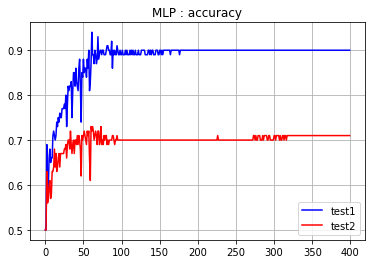

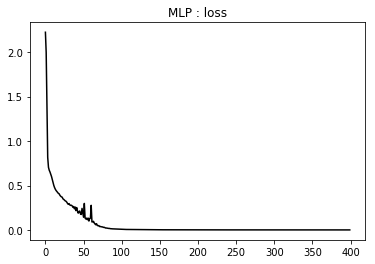

In [0]:
show_plot('MLP')
mlp_test_accuracy_lst = test_accuracy_lst[:]
mlp_test2_accuracy_lst = test2_accuracy_lst[:]

In [0]:
print(mlp_test_accuracy_lst)
print(mlp_test2_accuracy_lst)

[0.5, 0.5, 0.69, 0.59, 0.6, 0.66, 0.68, 0.65, 0.66, 0.66, 0.71, 0.72, 0.71, 0.7, 0.71, 0.74, 0.73, 0.75, 0.74, 0.76, 0.75, 0.75, 0.77, 0.77, 0.77, 0.78, 0.77, 0.8, 0.73, 0.78, 0.82, 0.81, 0.82, 0.82, 0.83, 0.75, 0.81, 0.85, 0.85, 0.82, 0.86, 0.83, 0.82, 0.81, 0.86, 0.88, 0.82, 0.74, 0.85, 0.84, 0.88, 0.85, 0.86, 0.86, 0.84, 0.88, 0.86, 0.9, 0.81, 0.83, 0.87, 0.94, 0.89, 0.89, 0.87, 0.9, 0.89, 0.87, 0.88, 0.93, 0.88, 0.89, 0.9, 0.9, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89, 0.9, 0.91, 0.91, 0.9, 0.9, 0.89, 0.89, 0.92, 0.86, 0.9, 0.89, 0.9, 0.89, 0.89, 0.91, 0.9, 0.89, 0.89, 0.9, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.89, 0.9, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89, 0.9, 0.9, 0.9, 0.89, 0.89, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.89,

In [0]:
mlp_model2 = SimpleMLP_Sigmoid().cuda()
train_loss_lst = []
test_accuracy_lst = []
test2_accuracy_lst = []
for epoch in range(total_epoch):
  train_loss = train(mlp_model2, train_loader)
  train_loss_lst.append(train_loss)
  test_accuracy = eval(mlp_model2, test_loader)
  test_accuracy_lst.append(test_accuracy)
  test2_accuracy = eval(mlp_model2, test2_loader)
  test2_accuracy_lst.append(test2_accuracy)
  
  print_accuracy(10)

summary(mlp_model2, input_size = (3, 32, 32))

1   loss : 1.1349188923835754, test_accuracy : 50.0%, test2_accuracy : 50.0%
10  loss : 0.7058634370565414, test_accuracy : 50.0%, test2_accuracy : 50.0%
20  loss : 0.6986559152603149, test_accuracy : 50.0%, test2_accuracy : 50.0%
30  loss : 0.6975546151399612, test_accuracy : 50.0%, test2_accuracy : 50.0%
40  loss : 0.6956132799386978, test_accuracy : 50.0%, test2_accuracy : 50.0%
50  loss : 0.6960506498813629, test_accuracy : 50.0%, test2_accuracy : 50.0%
60  loss : 0.6952345043420791, test_accuracy : 50.0%, test2_accuracy : 50.0%
70  loss : 0.6955744385719299, test_accuracy : 50.0%, test2_accuracy : 50.0%
80  loss : 0.6961924612522126, test_accuracy : 50.0%, test2_accuracy : 50.0%
90  loss : 0.6942451566457748, test_accuracy : 50.0%, test2_accuracy : 50.0%
100 loss : 0.6968018591403962, test_accuracy : 50.0%, test2_accuracy : 50.0%
110 loss : 0.6965848475694656, test_accuracy : 50.0%, test2_accuracy : 50.0%
120 loss : 0.6946480929851532, test_accuracy : 50.0%, test2_accuracy : 50.0%

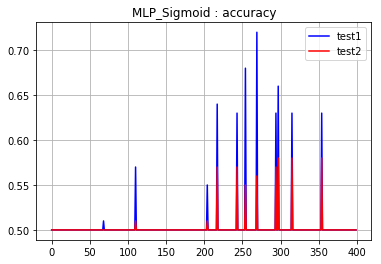

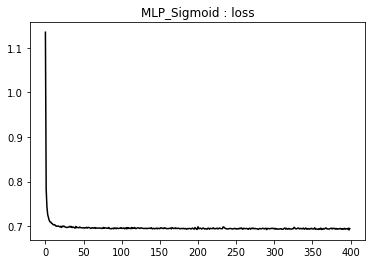

In [0]:
show_plot('MLP_Sigmoid')
mlp2_test_accuracy_lst = test_accuracy_lst[:]
mlp2_test2_accuracy_lst = test2_accuracy_lst[:]

In [0]:
print(mlp2_test_accuracy_lst)
print(mlp2_test2_accuracy_lst)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.57, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

In [0]:
cnn_model = SimpleCNN().cuda()
train_loss_lst = []
test_accuracy_lst = []
test2_accuracy_lst = []
for epoch in range(total_epoch):
  train_loss = train(cnn_model, train_loader)
  train_loss_lst.append(train_loss)
  test_accuracy = eval(cnn_model, test_loader)
  test_accuracy_lst.append(test_accuracy)
  test2_accuracy = eval(cnn_model, test2_loader)
  test2_accuracy_lst.append(test2_accuracy)
  
  print_accuracy(10)

summary(cnn_model, input_size = (3,32,32))

1   loss : 2.254405379295349, test_accuracy : 50.0%, test2_accuracy : 50.0%
10  loss : 0.6901502847671509, test_accuracy : 50.0%, test2_accuracy : 50.0%
20  loss : 0.6676603585481644, test_accuracy : 50.0%, test2_accuracy : 50.0%
30  loss : 0.5215835377573967, test_accuracy : 73.0%, test2_accuracy : 60.0%
40  loss : 0.4135130301117897, test_accuracy : 68.0%, test2_accuracy : 67.0%
50  loss : 0.3939335271716118, test_accuracy : 77.0%, test2_accuracy : 65.0%
60  loss : 0.3644639879465103, test_accuracy : 76.0%, test2_accuracy : 67.0%
70  loss : 0.32520708441734314, test_accuracy : 75.0%, test2_accuracy : 69.0%
80  loss : 0.2971441425383091, test_accuracy : 81.0%, test2_accuracy : 73.0%
90  loss : 0.2616378583014011, test_accuracy : 77.0%, test2_accuracy : 67.0%
100 loss : 0.24320896938443184, test_accuracy : 80.0%, test2_accuracy : 70.0%
110 loss : 0.16800524592399596, test_accuracy : 85.0%, test2_accuracy : 73.0%
120 loss : 0.14209079891443252, test_accuracy : 84.0%, test2_accuracy : 73

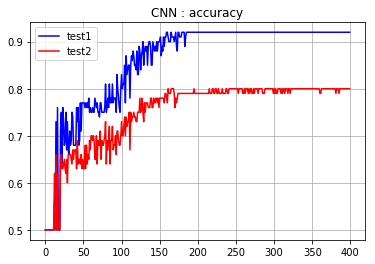

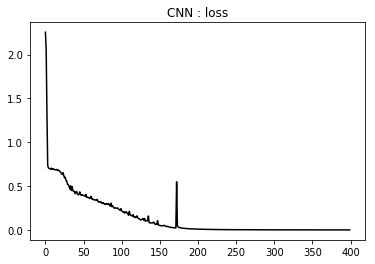

In [0]:
show_plot('CNN')
cnn_test_accuracy_lst = test_accuracy_lst[:]
cnn_test2_accuracy_lst = test2_accuracy_lst[:]

In [0]:
print(cnn_test_accuracy_lst)
print(cnn_test2_accuracy_lst)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.56, 0.5, 0.73, 0.5, 0.76, 0.5, 0.5, 0.5, 0.71, 0.75, 0.64, 0.76, 0.73, 0.68, 0.69, 0.75, 0.67, 0.73, 0.67, 0.66, 0.71, 0.68, 0.69, 0.75, 0.74, 0.68, 0.68, 0.68, 0.68, 0.76, 0.73, 0.76, 0.68, 0.69, 0.77, 0.71, 0.77, 0.77, 0.77, 0.77, 0.76, 0.77, 0.76, 0.77, 0.76, 0.78, 0.75, 0.76, 0.75, 0.75, 0.76, 0.75, 0.75, 0.78, 0.77, 0.76, 0.77, 0.75, 0.75, 0.74, 0.77, 0.77, 0.75, 0.75, 0.75, 0.75, 0.76, 0.81, 0.75, 0.76, 0.78, 0.76, 0.81, 0.77, 0.78, 0.77, 0.81, 0.77, 0.78, 0.78, 0.78, 0.75, 0.83, 0.8, 0.78, 0.76, 0.75, 0.8, 0.83, 0.8, 0.81, 0.81, 0.85, 0.77, 0.87, 0.83, 0.84, 0.85, 0.85, 0.78, 0.85, 0.87, 0.86, 0.88, 0.87, 0.85, 0.85, 0.84, 0.88, 0.83, 0.83, 0.89, 0.88, 0.84, 0.87, 0.88, 0.9, 0.85, 0.88, 0.89, 0.88, 0.89, 0.85, 0.89, 0.9, 0.9, 0.89, 0.85, 0.85, 0.9, 0.89, 0.88, 0.89, 0.88, 0.9, 0.88, 0.9, 0.9, 0.9, 0.91, 0.87, 0.89, 0.88, 0.91, 0.89, 0.91, 0.91, 0.92, 0.92, 0.91, 0.9, 0.9, 0.9, 0.92, 0.91, 0.91, 0.91, 0.9, 0.91, 0.92,

In [0]:
vgg_model = SimpleVGG().cuda()
train_loss_lst = []
test_accuracy_lst = []
test2_accuracy_lst = []
for epoch in range(total_epoch):
  train_loss = train(vgg_model, train_loader)
  train_loss_lst.append(train_loss)
  test_accuracy = eval(vgg_model, test_loader)
  test_accuracy_lst.append(test_accuracy)
  test2_accuracy = eval(vgg_model, test2_loader)
  test2_accuracy_lst.append(test2_accuracy)
  
  print_accuracy(10)
  
summary(vgg_model, input_size = (3,32,32))

1   loss : 2.250380790233612, test_accuracy : 50.0%, test2_accuracy : 50.0%
10  loss : 1.4076824128627776, test_accuracy : 50.0%, test2_accuracy : 50.0%
20  loss : 0.7043595671653747, test_accuracy : 50.0%, test2_accuracy : 50.0%
30  loss : 0.6943374991416931, test_accuracy : 50.0%, test2_accuracy : 50.0%
40  loss : 0.6931436032056808, test_accuracy : 50.0%, test2_accuracy : 50.0%
50  loss : 0.6913224190473557, test_accuracy : 52.0%, test2_accuracy : 56.00000000000001%
60  loss : 0.6927987962961197, test_accuracy : 50.0%, test2_accuracy : 50.0%
70  loss : 0.6897796601057052, test_accuracy : 50.0%, test2_accuracy : 50.0%
80  loss : 0.689478975534439, test_accuracy : 67.0%, test2_accuracy : 64.0%
90  loss : 0.6893200874328613, test_accuracy : 52.0%, test2_accuracy : 56.99999999999999%
100 loss : 0.6862572759389878, test_accuracy : 55.00000000000001%, test2_accuracy : 64.0%
110 loss : 0.6837357133626938, test_accuracy : 55.00000000000001%, test2_accuracy : 65.0%
120 loss : 0.6756221085786

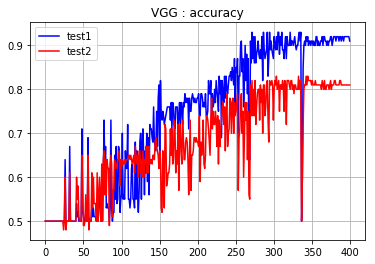

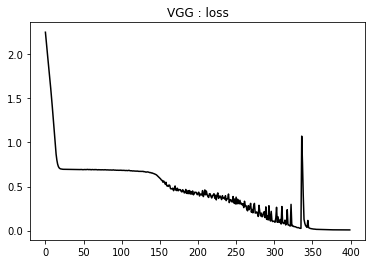

In [0]:
show_plot('VGG')
vgg_test_accuracy_lst = test_accuracy_lst[:]
vgg_test2_accuracy_lst = test2_accuracy_lst[:]

In [0]:
print(vgg_test_accuracy_lst)
print(vgg_test2_accuracy_lst)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.64, 0.5, 0.5, 0.5, 0.5, 0.5, 0.67, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.54, 0.51, 0.52, 0.5, 0.5, 0.5, 0.5, 0.71, 0.52, 0.51, 0.5, 0.5, 0.52, 0.5, 0.5, 0.69, 0.51, 0.5, 0.5, 0.5, 0.53, 0.51, 0.53, 0.51, 0.51, 0.51, 0.5, 0.53, 0.5, 0.57, 0.55, 0.52, 0.5, 0.59, 0.5, 0.59, 0.73, 0.62, 0.67, 0.53, 0.54, 0.53, 0.53, 0.5, 0.53, 0.73, 0.53, 0.5, 0.52, 0.52, 0.65, 0.55, 0.67, 0.54, 0.55, 0.67, 0.66, 0.52, 0.55, 0.56, 0.7, 0.55, 0.56, 0.55, 0.66, 0.62, 0.62, 0.72, 0.55, 0.55, 0.53, 0.55, 0.62, 0.63, 0.55, 0.55, 0.53, 0.68, 0.55, 0.66, 0.56, 0.52, 0.57, 0.68, 0.7, 0.55, 0.68, 0.71, 0.65, 0.56, 0.66, 0.61, 0.7, 0.59, 0.69, 0.56, 0.72, 0.71, 0.71, 0.69, 0.68, 0.76, 0.68, 0.67, 0.66, 0.75, 0.67, 0.78, 0.81, 0.65, 0.82, 0.74, 0.73, 0.75, 0.74, 0.72, 0.73, 0.74, 0.75, 0.76, 0.76, 0.76, 0.76, 0.73, 0.77, 0.71, 0.77, 0.76, 0.72, 0.71, 0.76, 0.76, 0.76, 0.7, 0.74, 0.7

In [0]:
resnet_model = SimpleResNet().cuda()
train_loss_lst = []
test_accuracy_lst = []
test2_accuracy_lst = []
for epoch in range(total_epoch):
  train_loss = train(resnet_model, train_loader)
  train_loss_lst.append(train_loss)
  test_accuracy = eval(resnet_model, test_loader)
  test_accuracy_lst.append(test_accuracy)
  test2_accuracy = eval(resnet_model, test2_loader)
  test2_accuracy_lst.append(test2_accuracy)  
  
  print_accuracy(10)
  
summary(resnet_model, input_size = (3,32,32))

1   loss : 2.2407400369644166, test_accuracy : 50.0%, test2_accuracy : 50.0%
10  loss : 0.6869306445121766, test_accuracy : 50.0%, test2_accuracy : 50.0%
20  loss : 0.5807142436504364, test_accuracy : 65.0%, test2_accuracy : 64.0%
30  loss : 0.48481071591377256, test_accuracy : 71.0%, test2_accuracy : 64.0%
40  loss : 0.44343319833278655, test_accuracy : 75.0%, test2_accuracy : 56.99999999999999%
50  loss : 0.4162813171744347, test_accuracy : 69.0%, test2_accuracy : 65.0%
60  loss : 0.4040405511856079, test_accuracy : 74.0%, test2_accuracy : 66.0%
70  loss : 0.37982968538999556, test_accuracy : 75.0%, test2_accuracy : 66.0%
80  loss : 0.36403709650039673, test_accuracy : 76.0%, test2_accuracy : 67.0%
90  loss : 0.34194659292697904, test_accuracy : 75.0%, test2_accuracy : 68.0%
100 loss : 0.31123619750142095, test_accuracy : 77.0%, test2_accuracy : 71.0%
110 loss : 0.2704071342945099, test_accuracy : 80.0%, test2_accuracy : 70.0%
120 loss : 0.2486683838069439, test_accuracy : 81.0%, tes

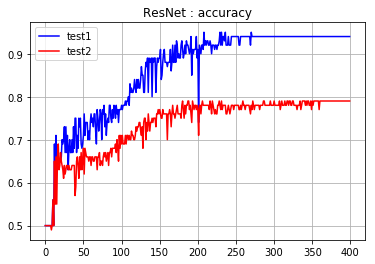

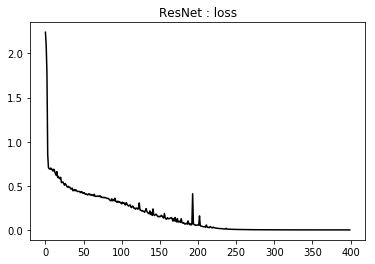

In [0]:
show_plot('ResNet')
resnet_test_accuracy_lst = test_accuracy_lst[:]
resnet_test2_accuracy_lst = test2_accuracy_lst[:]

In [0]:
print(resnet_test_accuracy_lst)
print(resnet_test2_accuracy_lst)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.56, 0.5, 0.69, 0.56, 0.71, 0.64, 0.67, 0.66, 0.65, 0.65, 0.65, 0.66, 0.7, 0.69, 0.7, 0.73, 0.67, 0.73, 0.67, 0.71, 0.63, 0.68, 0.7, 0.67, 0.67, 0.7, 0.67, 0.73, 0.68, 0.75, 0.75, 0.67, 0.71, 0.68, 0.75, 0.73, 0.75, 0.69, 0.68, 0.69, 0.71, 0.76, 0.71, 0.74, 0.74, 0.74, 0.7, 0.72, 0.7, 0.74, 0.76, 0.74, 0.75, 0.73, 0.76, 0.76, 0.72, 0.69, 0.77, 0.75, 0.72, 0.74, 0.77, 0.76, 0.7, 0.77, 0.76, 0.78, 0.73, 0.76, 0.71, 0.74, 0.75, 0.74, 0.78, 0.78, 0.75, 0.74, 0.77, 0.75, 0.78, 0.77, 0.75, 0.78, 0.76, 0.77, 0.74, 0.77, 0.77, 0.77, 0.78, 0.77, 0.78, 0.78, 0.78, 0.79, 0.78, 0.79, 0.79, 0.8, 0.78, 0.83, 0.81, 0.82, 0.81, 0.81, 0.82, 0.84, 0.82, 0.81, 0.84, 0.82, 0.84, 0.82, 0.82, 0.84, 0.87, 0.85, 0.85, 0.81, 0.81, 0.86, 0.88, 0.87, 0.89, 0.81, 0.89, 0.88, 0.88, 0.89, 0.8, 0.89, 0.88, 0.89, 0.89, 0.81, 0.87, 0.89, 0.88, 0.89, 0.89, 0.91, 0.84, 0.85, 0.88, 0.9, 0.91, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.91, 0.86, 0.88, 0.92, 0.88, 0.88, 

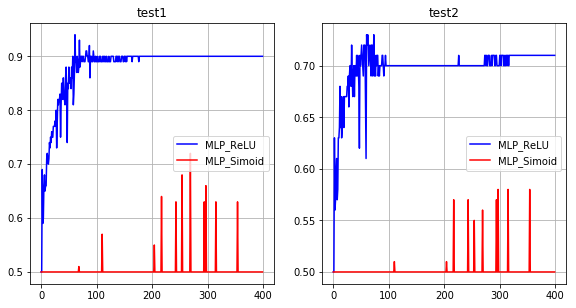

In [0]:
plt.figure(figsize=(9.6,4.8))
plt.subplot(121)
plt.plot(mlp_test_accuracy_lst, 'b-', label='MLP_ReLU')
plt.plot(mlp2_test_accuracy_lst, 'r-', label='MLP_Simoid')
plt.grid()
plt.legend()
plt.title('test1')

plt.subplot(122)
plt.plot(mlp_test2_accuracy_lst, 'b-', label='MLP_ReLU')
plt.plot(mlp2_test2_accuracy_lst, 'r-', label='MLP_Simoid')
plt.grid()
plt.legend()
plt.title('test2')

plt.show()

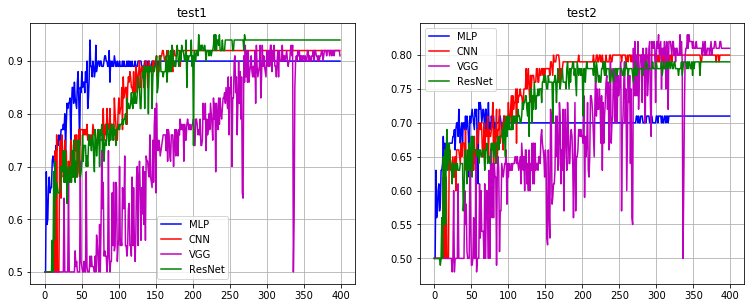

In [0]:
plt.figure(figsize=(12.8,4.8))
plt.subplot(121)
plt.plot(mlp_test_accuracy_lst, 'b-', label='MLP')
plt.plot(cnn_test_accuracy_lst, 'r-', label='CNN')
plt.plot(vgg_test_accuracy_lst, 'm-', label='VGG')
plt.plot(resnet_test_accuracy_lst, 'g-', label='ResNet')
plt.title('test1')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(mlp_test2_accuracy_lst, 'b-', label='MLP')
plt.plot(cnn_test2_accuracy_lst, 'r-', label='CNN')
plt.plot(vgg_test2_accuracy_lst, 'm-', label='VGG')
plt.plot(resnet_test2_accuracy_lst, 'g-', label='ResNet')
plt.title('test2')
plt.grid()
plt.legend()

plt.show()